In [1]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

In [2]:
# mpl.use("pgf")  # to display graphs remove this line
mpl.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
line = 0.75

In [3]:
# general settings for signal and noise
length = 0.2  # in s
noise_power = 10.0  # in dB
num_bands = 10

# create 'WidebandSignal' object
wbs = ss.WidebandSignal(t_sec=length, num_bands=num_bands, num_steps=10)

# signal power matrix (dimensions: num_bands x num_steps)
mat = np.array([[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100, -100,   -3,    0,    3,    5,    7,   10, -100, -100],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100,    0,    3,    3,    0, -100,    0,    5,    0, -100],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100, -100,   10,    5,    0,   -5,   -7,  -10,  -13, -100],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100, -100, -100, -100, -100,    0,    0, -100, -100, -100],
                [-100,   10,   10,   10, -100, -100, -100, -100, -100, -100],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100]])

# # plot the matrix
# wbs.plot(mat)

# generate actual signal from matrix
sig, sample_freq = wbs.signal(mat)

# create the noise
wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)
noise = wgn.signal(power=noise_power, dB=True)

# ensure noise and signal have same length (and create global variable 'num_samples')
assert wbs.num_samples == wgn.num_samples
num_samples = wbs.num_samples

# create actual signal ('both') comprising of signal and additive white Gaussian noise (AWGN)
both = sig + noise

# print some info about signal and noise
print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num samples:  %d' % (num_samples))

# ensure that Parseval's theorem holds
ss.util.check_parseval(both, length, sample_freq)

Created WidebandSignal with 1.0 MHz total bandwidth and 20000 samples per step.
Signal power: 8.87 dB
Noise power:  10.00 dB
SNR:          -1.12 dB
Num samples:  200000


In [4]:
# wide band energy detector with 'fft_len' window length
fft_len = 1024

# create a Short Time Fourier Transform object
sft = ss.Stft(n=fft_len, window='box')

# use the stft to transform the signal into the frequency domain
f, t, x = sft.spectogram(both, sample_freq, normalized=False, dB=False)

# create a Wideband Energy Detector object
fed = ss.WidebandEnergyDetector(num_bands=num_bands,
                                f_sample=sample_freq,
                                fft_len=fft_len,
                                freqs=f)

# compute the energy at every timestep
eng = np.asarray(list(map(fed.detect, x.T))).T

# # plot result of energy detector
# ss.util_wide.plot_matrix(eng, xlabel='Time / Num FFT', plabel='Energy')

In [5]:
# we set the probability of false alarm to our desired value
pfa = 0.01

# from that we calculate the threshold
thr = ss.chi2_stats.thr(noise_power=noise_power,
                        pfa=pfa,
                        n=fft_len // num_bands,
                        dB=True)

# and the probability of detection for 0dB signal power
pd = ss.chi2_stats.pd(noise_power=noise_power,
                      signal_power=0.,
                      thr=thr,
                      n=fft_len // num_bands,
                      dB=True,
                      num_bands=num_bands)

print('---- Stats theory ----')
print('Prob false alarm: %.5f' % (pfa))
print('Threshold:        %.5f' % (thr))
print('Prob detection:   %.5f' % (pd))

# apply threshold to result of energy detector matrix
res = (eng > thr) * np.full_like(eng, 1.)

# # plot the resulting binary decision matrix
# ss.util_wide.plot_matrix(res,
#                          xlabel='Time / Num FFT',
#                          plabel='Decision',
#                          binary=True)

print('---- Stats from matrix ----')
print('Simulation false alarm: %.5f' % (ss.util_wide.mat_pfa(res, mat)))
print('Simulation Detection:   %.5f' % (ss.util_wide.mat_pd(res, mat)))

---- Stats theory ----
Prob false alarm: 0.01000
Threshold:        1269.54170
Prob detection:   0.99999
---- Stats from matrix ----
Simulation false alarm: 0.01573
Simulation Detection:   0.85744


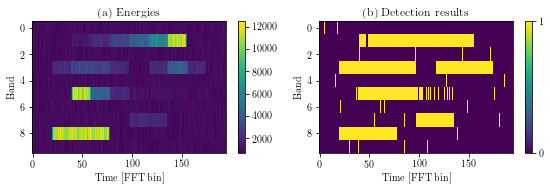

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2.75))

ax1.set_title(r'(a) Energies')
img = ax1.imshow(eng, aspect='auto')
ax1.set_xlabel(r'Time [FFT bin]')
ax1.set_ylabel(r'Band')
cbar = plt.colorbar(img, ax=ax1)
# cbar.set_label(r'Energy')

ax2.set_title(r'(b) Detection results')
img = ax2.imshow(res, aspect='auto')
ax2.set_xlabel(r'Time [FFT bin]')
ax2.set_ylabel(r'Band')
cbar = plt.colorbar(img, ax=ax2)
# cbar.set_label(r'Decision')
cbar.set_ticks([0, 1])

plt.tight_layout()
plt.savefig('out/chap5/wideband_detect.pdf')

In [7]:
print(eng.shape)

(10, 195)
